In [1]:
import pandas as pd
import requests
import re
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
#from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from collections import Counter
from pywaffle import Waffle
import squarify

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Татьяна\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
TOKEN = 'f6eb8e76f6468f6cd650fe64ce2cbd0d1a02cc5655ad7adad6c5f954bd88c42a0d14a0afe49fab5889a99'

Будем обкачивать 3 сообщества: "Подслушано в МГУ", "Подслушано ВШЭ" и "Подслушано МГИМО". Узнаем, о чем говорят студенты этих вузов!

## Подслушано МГУ

In [3]:
data = requests.get(
    'https://api.vk.com/method/wall.get', 
    params={
        "owner_id": -54295855,
        "count": 300,
        "v":"5.92",
        "access_token": TOKEN    
    }
).json()
#data

In [4]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()
from string import punctuation

data_str = json.dumps(data, ensure_ascii=False)
text_re = '"text": "(.*?)", ".*?":'
word_re = '[а-яА-ЯЁё]+'
text = re.findall(text_re, data_str)
text_str = " ".join(text)
word = re.findall(word_re, text_str)
word_df = pd.DataFrame(word, columns=['word'])
lemma_df = word_df.word.apply(lambda x: ' '.join(morph.parse(w.strip(punctuation))[0].normal_form for w in x.split()))

Для начала узнаем, какие самые частотные слова (топ-20) в "Подслушано в МГУ"

### Топ-20 слов

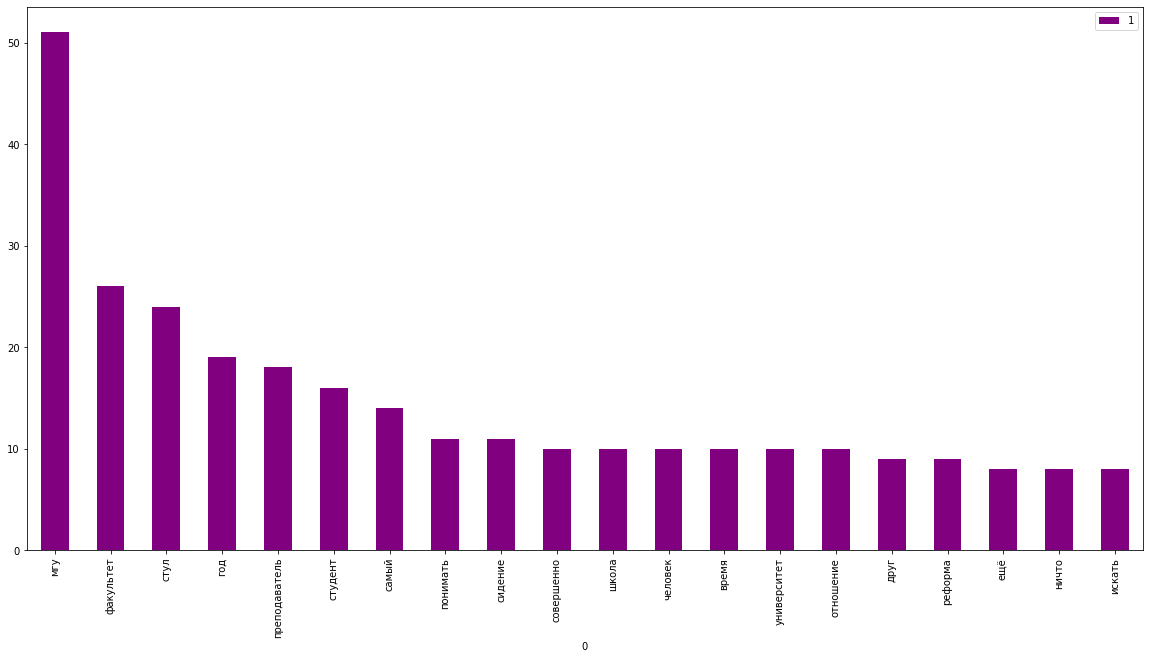

In [5]:
from nltk.corpus import stopwords
words = []
stopword_set = set(stopwords.words('russian'))
stopword_set.update(['в', 'нет', 'мы', 'я', 'когда', 'уже',
                     'это', 'весь', 'который', 'и', 'мочь',
                     'все', 'наш', 'ваш', 'свой' ])
#prog = re.compile(stopword_set, flags=re.IGNORECASE)
#print(stopword_set)

for word in lemma_df:
    words.extend([w for w in word.split() if w not in stopword_set])
word_count = Counter(words).most_common(20)
pd.DataFrame(word_count).set_index(0).plot(kind='bar', color='purple', figsize=(20, 10))

Интересные наблюдения: в сообществе почему-то часто говорят о стульях (3 место в топе! также "сидение" занимает 8 место). Название вуза занимает первое место в диаграмме частотности (с большим отрывом), а также в группе присутствуют другие типичные для учебного процесса слова ("факультет", "преподаватель", "студент" и т.п.)

### Частотность частей речи

Узнаем, насколько часто употребляются те или иные части речи.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0AEA74F0>],
      dtype=object)

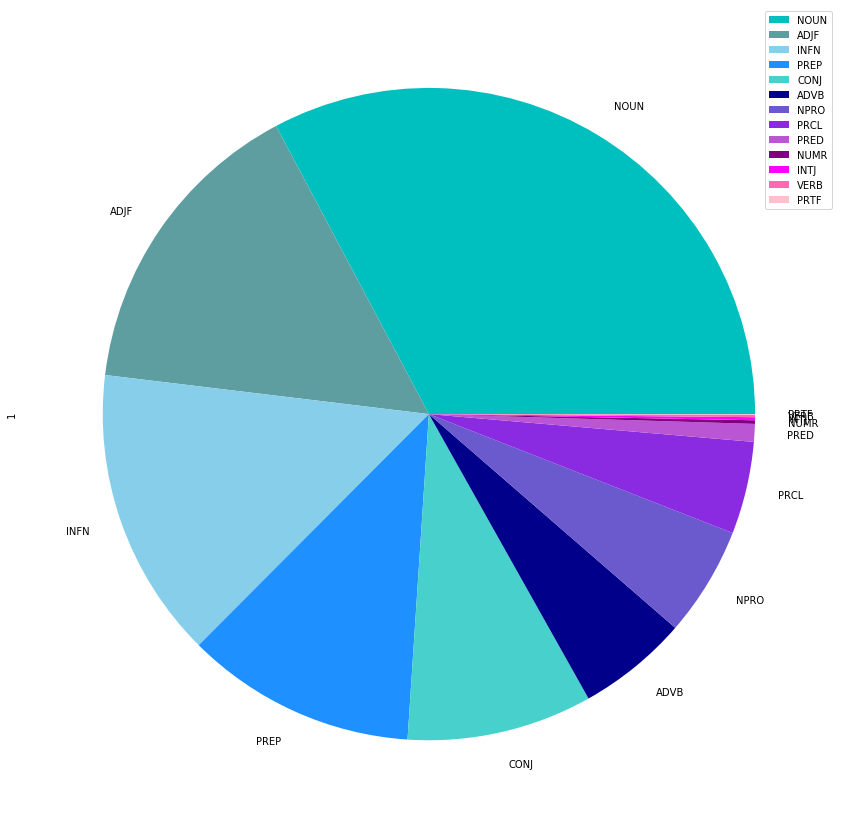

In [6]:
pos = []
for i in lemma_df:
    ana = morph.parse(i)
    first_ana = ana[0]
    pos.append(first_ana.tag.POS)
    pos_df = pd.DataFrame(pos, columns=['pos'])
    pos_quant = pos_df['pos'].value_counts()
    pos_quant_tup = [((x, y)) for x, y in pos_quant.items()]
    
colors = ['c', 'cadetblue', 'skyblue', 'dodgerblue', 'mediumturquoise',
         'darkblue', 'slateblue', 'blueviolet', 'mediumorchid',
         'purple', 'fuchsia', 'hotpink', 'pink']

pd.DataFrame(data=pos_quant_tup).set_index(0).plot(kind='pie', subplots=True, 
            colors=colors, figsize=(15, 15))

### Частотность одушевленных и неодушевленных сущ-ных

Узнаем теперь соотношение количества неодушевленных и одушевленных существительных!

inan    1045
anim     256
Name: animacy, dtype: int64


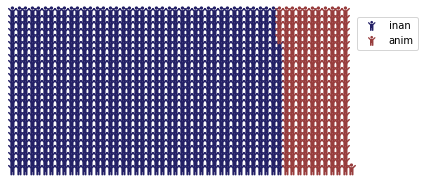

In [8]:
import matplotlib.pyplot as plt
from pywaffle import Waffle

anim = []
for i in lemma_df:
    ana = morph.parse(i)
    first_ana = ana[0]
    if first_ana.tag.POS == 'NOUN':
        anim.append(first_ana.tag.animacy)
        anim_df = pd.DataFrame(anim, columns=['animacy'])
        anim_q = anim_df['animacy'].value_counts()
print(anim_q)
    
#res = {anim_only[i] : quant_only[i] for i, _ in enumerate(quant_only)}
res = {'inan': 1045, 'anim': 256}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=25, 
    values= res,
    colors=("#232066", "#983D3D"),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons='child', 
    font_size=12, 
    icon_legend=True
)
plt.show()

Количество неодушевленных сущ-ных, т.е. синих человечков, как видно, гораздо больше количества одушевленных. Еще нагляднее это демонстрирует гистограмма ниже.

Text(0, 0.5, 'количество')

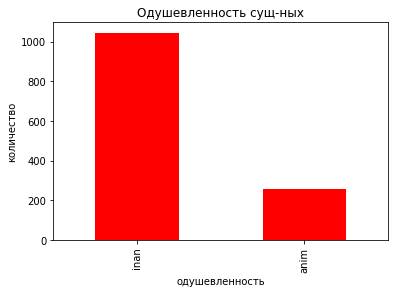

In [9]:
anim_q.plot.bar(color='red')
plt.title('Одушевленность сущ-ных')
plt.xlabel('одушевленность')
plt.ylabel('количество')

Итак, теперь мы знаем, что в сообществе "Подслушано в МГУ" упоминают неодушевленные предметы почти в 4 раза чаще, чем людей (хорошо, что не наоборот).

## Подслушано МГИМО

In [10]:
data2 = requests.get(
    'https://api.vk.com/method/wall.get', 
    params={
        "owner_id": -57969268,
        "count": 300,
        "v":"5.92",
        "access_token": TOKEN    
    }
).json()

Посмотрим теперь, о чем говорят в МГИМО. Для начала выведем 20 самых популярных слов.

## Топ-20 слов

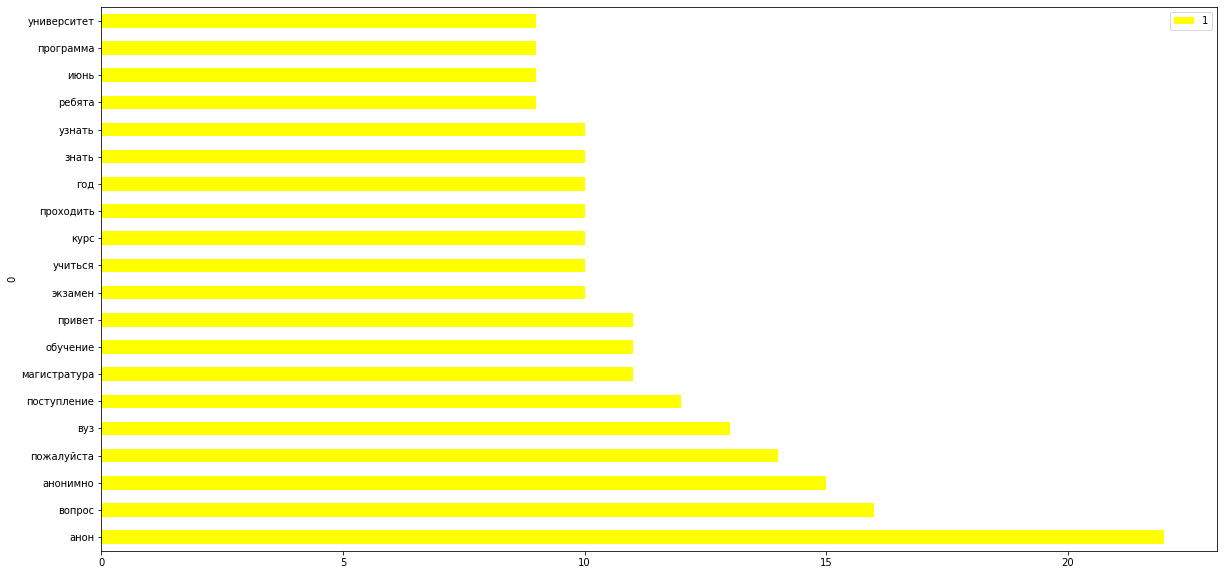

In [11]:
data_str2 = json.dumps(data2, ensure_ascii=False)
text_re = '"text": "(.*?)", ".*?":'
word_re = '[а-яА-ЯЁё]+'
text2 = re.findall(text_re, data_str2)
text_str2 = " ".join(text2)
word2 = re.findall(word_re, text_str2)
word_df2 = pd.DataFrame(word2, columns=['word'])
lemma_df2 = word_df2.word.apply(lambda x: ' '.join(morph.parse(w.strip(punctuation))[0].normal_form for w in x.split()))

words2 = []
stopword_set = set(stopwords.words('russian'))
stopword_set.update(['в', 'нет', 'мы', 'я', 'когда',
                     'это', 'весь', 'который', 'и', 'мочь',
                     'все', 'наш', 'ваш', 'свой' ])
#prog = re.compile(stopword_set, flags=re.IGNORECASE)
#print(stopword_set)

for word in lemma_df2:
    words2.extend([w for w in word.split() if w not in stopword_set])
word_count2 = Counter(words2).most_common(20)
pd.DataFrame(word_count2).set_index(0).plot(kind='barh', color='yellow', figsize=(20, 10))

Первое, что бросается в глаза - "мгимо" не находится в списке самых популярных слов группы ни на одной позиции (в предыдущей группе, однако, "мгу" было самым частотным словом с большим отрывом).
Примечательно также, что, в отличие от "Подслуашано в МГУ", "Подслушано МГИМО" служит скорее платформой для вопросов/просьб от студентов, а не источником с актуальными новостями/мемами, о чем говорят слова "анон", "вопрос", "анонимно" (первое-третье места), а также некоторые другие ключевые слова из топа, в том числе "пожалуйста", "узнать", "ребята" и т.п.

## Топ-5 наречий

Посмотрим, какие наречия встречаются чаще всего в "Подслушано МГИМО" 

In [12]:
pos2 = []
lemma_df2 = word_df2.word.apply(lambda x: ' '.join(morph.parse(w.strip(punctuation))[0].normal_form for w in x.split()))
for i in lemma_df2:
    ana2 = morph.parse(i)
    first_ana2 = ana2[0]
    pos2.append(first_ana2.tag.POS)
    pos_df2 = pd.DataFrame(pos2, columns=['pos'])
    pos_quant2 = pos_df2['pos'].value_counts()
    pos_quant_tup2 = [((x, y)) for x, y in pos_quant2.items()]

colors2 = ['c', 'cadetblue', 'skyblue', 'dodgerblue', 'mediumturquoise',
         'darkblue', 'slateblue', 'blueviolet', 'mediumorchid',
         'purple', 'fuchsia', 'hotpink']

(Уберем также некоторые "стоп-наречия", которые в принципе часто встречаются в речи)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0F27BA70>],
      dtype=object)

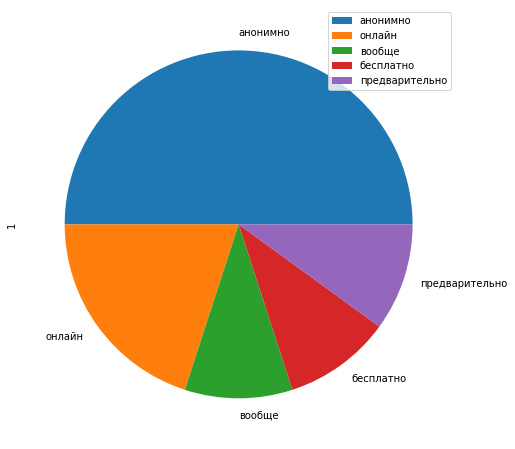

In [13]:
adv = []
for i in lemma_df2:
    ana = morph.parse(i)
    first_ana = ana[0]
    if first_ana.tag.POS == 'ADVB':
        if i != 'уже' and i !='сейчас' and i !='где' and i !='очень':
            adv.append(i)
        #adv_df = pd.DataFrame(adv, columns=['adv'])
        #adv_q = adv_df['adv'].value_counts()
              
adv_count = Counter(adv).most_common(5)
pd.DataFrame(adv_count).set_index(0).plot(kind='pie', subplots=True, figsize=(15, 8))

Кажется, участники группы очень боятся нарушения конфиденциальности ("анонимно" на первом месте по частотности и составляет почти половину всех употреблений из топ-5 наречий)!

masc    302
femn    200
neut    109
Name: gender, dtype: int64


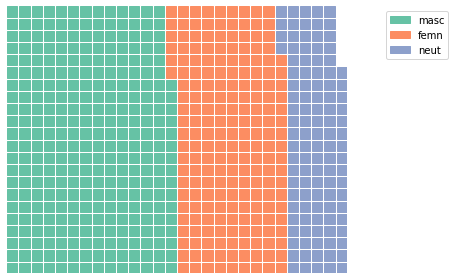

In [20]:
gen = []
for i in lemma_df2:
    ana = morph.parse(i)
    first_ana = ana[0]
    if first_ana.tag.POS == 'NOUN':
        gen.append(first_ana.tag.gender)
        gen_df = pd.DataFrame(gen, columns=['gender'])
        gen_q = gen_df['gender'].value_counts()  
print(gen_q)        
data = {'masc': 302, 'femn': 200, 'neut': 109}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=22, 
    values=data, 
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()        

## Подслушано ВШЭ

In [21]:
data3 = requests.get(
    'https://api.vk.com/method/wall.get', 
    params={
        "owner_id": -57354358,
        "count": 300,
        "v":"5.92",
        "access_token": TOKEN    
    }
).json()

Наконец-то обкачиваем "Подслушано" родного вуза - "Подслушано ВШЭ"! По традиции сначала узнаем самые популярные слова.

## Топ-20 слов

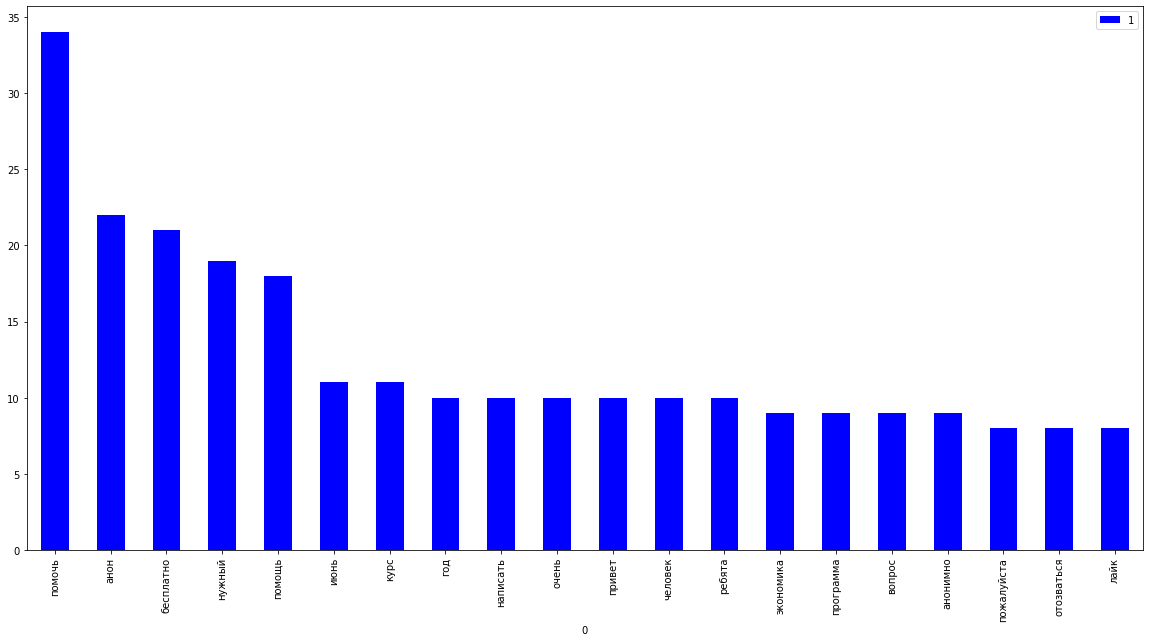

In [49]:
data_str3 = json.dumps(data3, ensure_ascii=False)
text_re = '"text": "(.*?)", ".*?":'
word_re = '[а-яА-ЯЁё]+'
text3 = re.findall(text_re, data_str3)
text_str3 = " ".join(text3)
word3 = re.findall(word_re, text_str3)
word_df3 = pd.DataFrame(word3, columns=['word'])
lemma_df3 = word_df3.word.apply(lambda x: ' '.join(morph.parse(w.strip(punctuation))[0].normal_form for w in x.split()))

words3 = []
stopword_set = set(stopwords.words('russian'))
stopword_set.update(['в', 'нет', 'мы', 'я', 'когда',
                     'это', 'весь', 'который', 'и', 'мочь',
                     'все', 'наш', 'ваш', 'свой' ])
#prog = re.compile(stopword_set, flags=re.IGNORECASE)
#print(stopword_set)
adjvs3 = ['английский', 'английский', 'английский', 'английский', 'английский',
      'богатый', 'богатый', 'богатый','богатый','богатый',
      'добрый','добрый','добрый','добрый','добрый','добрый','добрый',
      'добрый','добрый', 'международный','международный','международный','международный',
      'международный','международный', 'второй','второй','второй',
      'вычислительный','вычислительный','вычислительный','вычислительный',
      'вычислительный','вычислительный','вычислительный','вычислительный',
      'плохой','плохой','плохой','плохой','плохой','плохой',
      'открытый','открытый','открытый','открытый','открытый','открытый']

for word in lemma_df3:
    words3.extend([w for w in word.split() if w not in stopword_set])
word_count3 = Counter(words3).most_common(20)
pd.DataFrame(word_count3).set_index(0).plot(kind='bar', color='blue', figsize=(20, 10))

Очевидно, что "Подслушано ВШЭ" функционирует прежде всего как сообщество взаимопомощи ("помочь" на первом месте; наличие слов "ребята", "пожалуйста", "помощь" и т.п. в топ-10). Кроме того, как и для "Подслуашно МГИМО", для пользователей "Подслушано ВШЭ" также характерно желание оставлять анонимные записи. Само название университета, как и в "Подслушано МГИМО", здесь также отсутствует в топ-20 слов.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0F062310>],
      dtype=object)

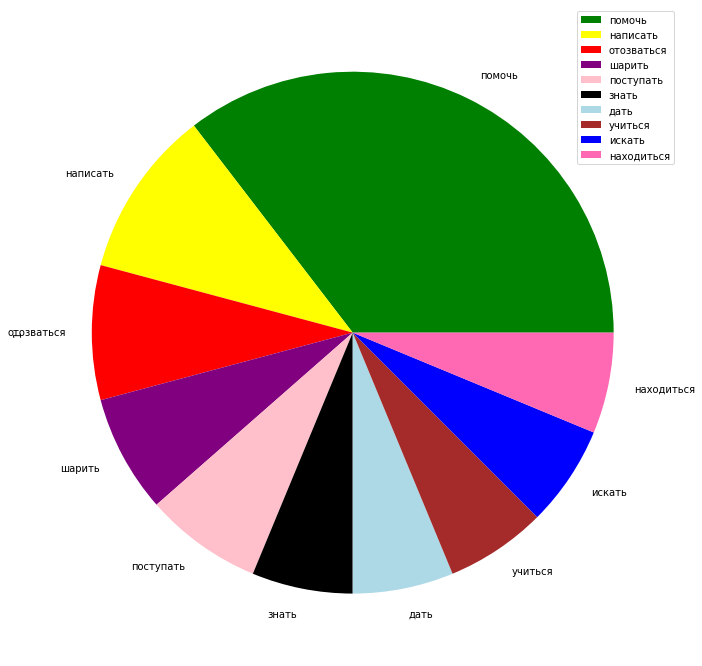

In [23]:
verbs = []
for i in lemma_df3:
    ana = morph.parse(i)
    first_ana = ana[0]
    if first_ana.tag.POS == 'INFN':
        if i != 'быть' and i != 'иметь' and i != 'делать':
            verbs.append(i)
        
col = ['green', 'yellow', 'red', 'purple', 'pink', 'black', 'lightblue', 
       'brown', 'blue', 'hotpink']

verb_count = Counter(verbs).most_common(10)
pd.DataFrame(verb_count).set_index(0).plot(kind='pie', subplots=True, colors=col, figsize=(12, 12))
    
#res = {anim_only[i] : quant_only[i] for i, _ in enumerate(quant_only)}

[('английский', 5), ('богатый', 5), ('российский', 3), ('добрый', 3), ('важный', 3)]


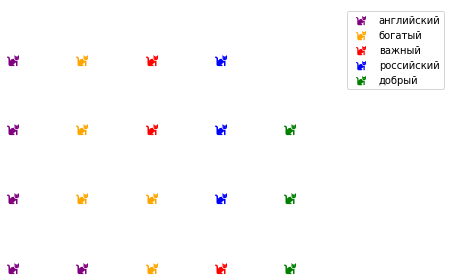

In [55]:
adj3 = []
for i in lemma_df3:
    ana = morph.parse(i)
    first_ana = ana[0]
    if first_ana.tag.POS == 'ADJF':
        if i != 'который' and i != 'весь' and i != 'тот' and i != 'этот' and i != 'какой' and i != 'свой' and i != 'угодный'  and i != 'готовый' and i != 'ваш' and i != 'другой' and i != 'нужный':
            adj3.append(i)
            
adj_count3 = Counter(adj3).most_common(5)
print(adj_count3)

res = {'английский': 5, 'богатый': 5, 'важный': 3, 'российский':3, 'добрый':3}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=4, 
    values= res,
    colors=("purple", "orange", "red", "blue", "green"),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons='cat', 
    font_size=12, 
    icon_legend=True
)
plt.show()

## График-сравнение по всем сообществам

Время строить вордклауд из всех популярных слов по всем сообществам!

[('английский', 5), ('богатый', 5), ('добрый', 3)]
[('добрый', 6), ('международный', 6), ('второй', 3)]
[('вычислительный', 8), ('плохой', 6), ('открытый', 6)]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0DBC43D0>],
      dtype=object)

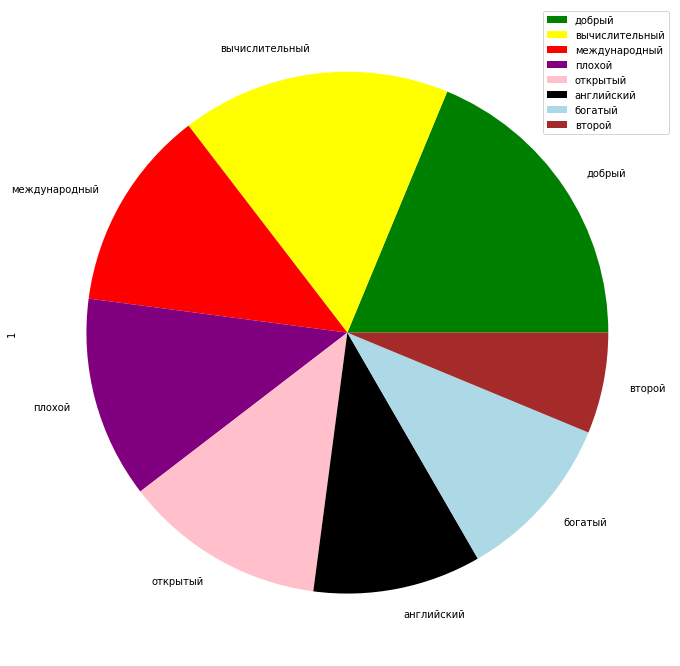

In [65]:
print("[('английский', 5), ('богатый', 5), ('добрый', 3)]")
print("[('добрый', 6), ('международный', 6), ('второй', 3)]")
adj2 = []
for i in lemma_df2:
    ana = morph.parse(i)
    first_ana = ana[0]
    if first_ana.tag.POS == 'ADJF':
        if i != 'который' and i != 'весь' and i != 'тот' and i != 'этот' and i != 'какой' and i != 'ваш' and i != 'свой' and i != 'такой' and i != 'один' and i != 'наш' and i != 'другой' and i != 'нужный':
            adj2.append(i)
adj_count2 = Counter(adj2).most_common(3)
            
adj = []
for i in lemma_df:
    ana = morph.parse(i)
    first_ana = ana[0]
    if first_ana.tag.POS == 'ADJF':
        if i != 'который' and i != 'весь' and i != 'тот' and i != 'самый' and i != 'угодный' and i != 'этот' and i != 'какой' and i != 'ваш' and i != 'другой' and i != 'свой' and i != 'такой' and i != 'один' and i != 'наш' and i != 'нужный':
            adj.append(i)
adj_count = Counter(adj).most_common(3)

adj_count33 = Counter(adj3).most_common(3)
print(adj_count)

adjvs3_count = Counter(adjvs3).most_common(8) 
pd.DataFrame(adjvs3_count).set_index(0).plot(kind='pie', subplots=True, colors=col, figsize=(12, 12))

Как было видно из диаграмм по самым популярным 20 словам раньше, в основном кол-во большинства слов из топ-20 слов примерно одинаково между собой, что стало еще нагляднее в диаграмме выше. Тем не менее, некоторые явные отличия от среднего кол-ва употребления слов все же остаются: так, заметно, что лидером все же стало слово "мгу" из первого сообщества; что в совокупности в первом и втором сообществах просьба не указывать имя автора ("анон") также стала выделяться из общей массы и вышла в лидеры, а также что, например, некоторые наречия находятся в самом низу данного топа.